# 0 Prep


In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
!pip install optuna==3.3.0
!pip install shap

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import seaborn as sns
import itertools
import optuna
import re
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error


In [46]:
df0 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Global_YouTube_Statistics.csv', encoding='latin-1')

# 1 Basic Information and Structure

In [47]:
 # Shape and Size: Get the number of rows and columns in the dataset.
df0.shape

(1006, 29)

In [48]:
# Change column names to lowercase and replace spaces with underscores
df0.columns = df0.columns.map(lambda x: re.sub('\s+', '_', x.lower().strip()))

In [49]:
df0.info()  # Data types and missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006 entries, 0 to 1005
Data columns (total 29 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   rank                                     1006 non-null   int64  
 1   youtuber                                 1006 non-null   object 
 2   subscribers                              1003 non-null   float64
 3   video_views                              1006 non-null   object 
 4   category                                 951 non-null    object 
 5   title                                    1006 non-null   object 
 6   uploads                                  1006 non-null   int64  
 7   country_of_origin                        881 non-null    object 
 8   country                                  881 non-null    object 
 9   abbreviation                             881 non-null    object 
 10  channel_type                             974 non

In [50]:
# Clean variables

# Convert 'video_views' to numerical
df0['video_views'] = df0['video_views'].replace('-', pd.NA)
df0['video_views'] = pd.to_numeric(df0['video_views'], errors='coerce')


# Convert YEAR to numerical

# Replace NaN values with the median year
median_year = df0['created_year'].median()
df0['created_year_n'] = df0['created_year'].fillna(median_year)
df0['created_year_n'] = df0['created_year_n'].round(0).astype(int)

# Convert 'created_year' and 'created_date' to categorical
df0['created_year'] = pd.Categorical(df0['created_year'])
df0['created_month'] = pd.Categorical(df0['created_month'])
df0['created_date'] = pd.Categorical(df0['created_date'])


In [51]:
df0.info()  # check data types again

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006 entries, 0 to 1005
Data columns (total 30 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   rank                                     1006 non-null   int64   
 1   youtuber                                 1006 non-null   object  
 2   subscribers                              1003 non-null   float64 
 3   video_views                              997 non-null    float64 
 4   category                                 951 non-null    object  
 5   title                                    1006 non-null   object  
 6   uploads                                  1006 non-null   int64   
 7   country_of_origin                        881 non-null    object  
 8   country                                  881 non-null    object  
 9   abbreviation                             881 non-null    object  
 10  channel_type                        

In [52]:
df0.head()

,rank,youtuber,subscribers,video_views,category,title,uploads,country_of_origin,country,abbreviation,...,created_year,created_month,created_date,gross_tertiary_education_enrollment_pct,population,unemployment_rate,urban_population,latitude,longitude,created_year_n
0,1,T-Series,245000000.0,2.280000e+11,Music,T-Series,20082,India,india,IN,...,2006.0,Mar,13.0,28.1,1.366418e+09,5.36,471031528.0,20.593684,78.962880,2006
1,2,YouTube Movies,170000000.0,NaN,Film & Animation,youtubemovies,1,United States,United States,US,...,2006.0,NaN,5.0,88.2,3.282395e+08,14.70,270663028.0,37.090240,-95.712891,2006
2,3,MrBeast,166000000.0,2.836884e+10,Entertainment,MrBeast,741,United States,United States,US,...,2012.0,Feb,20.0,88.2,3.282395e+08,14.70,270663028.0,37.090240,-95.712891,2012
3,4,Cocomelon - Nursery Rhymes,162000000.0,1.640000e+11,Education,Cocomelon - Nursery Rhymes,966,United States,United States,US,...,2006.0,Sep,1.0,88.2,3.282395e+08,14.70,270663028.0,37.090240,-95.712891,2006
4,5,SET India,159000000.0,1.480000e+11,Shows,SET India,116536,India,India,IN,...,2006.0,Sep,20.0,28.1,1.366418e+09,5.36,471031528.0,20.593684,78.962880,2006


In [53]:
df0.tail()

,rank,youtuber,subscribers,video_views,category,title,uploads,country_of_origin,country,abbreviation,...,created_year,created_month,created_date,gross_tertiary_education_enrollment_pct,population,unemployment_rate,urban_population,latitude,longitude,created_year_n
1001,779,The Dodo,14200000.0,9.964117e+09,Pets & Animals,Dorukhan Gï¿½ï¿½ï,8,NaN,NaN,NaN,...,2006.0,Jun,14.0,NaN,NaN,NaN,NaN,NaN,NaN,2006
1002,787,Supercar Blondie,14100000.0,5.405563e+09,Autos & Vehicles,Supercar Blondie,855,United Arab Emirates,United Arab Emirates,AE,...,2007.0,Sep,12.0,36.8,9.770529e+06,2.35,8479744.0,23.424076,53.847818,2007
1003,871,Just For Laughs Gags,13300000.0,7.406629e+09,Comedy,Just For Laughs Gags,6916,United States,United States,US,...,2007.0,Jan,14.0,88.2,3.282395e+08,14.70,270663028.0,37.090240,-95.712891,2007
1004,872,Kabita's Kitchen,13300000.0,2.831276e+09,Howto & Style,Kabita's Kitchen,1489,India,India,IN,...,2014.0,Oct,7.0,28.1,1.366418e+09,5.36,471031528.0,20.593684,78.962880,2014
1005,873,BanderitaX,13300000.0,4.129249e+09,Gaming,BanderitaX,1640,Saudi Arabia,Saudi Arabia,SA,...,2013.0,Aug,20.0,68.0,3.426853e+07,5.93,28807838.0,23.885942,45.079162,2013


In [54]:
# Column Names: List the names of all columns.
df0.columns.tolist()

['rank',
 'youtuber',
 'subscribers',
 'video_views',
 'category',
 'title',
 'uploads',
 'country_of_origin',
 'country',
 'abbreviation',
 'channel_type',
 'video_views_rank',
 'country_rank',
 'channel_type_rank',
 'video_views_for_the_last_30_days',
 'lowest_monthly_earnings',
 'highest_monthly_earnings',
 'lowest_yearly_earnings',
 'highest_yearly_earnings',
 'subscribers_for_last_30_days',
 'created_year',
 'created_month',
 'created_date',
 'gross_tertiary_education_enrollment_pct',
 'population',
 'unemployment_rate',
 'urban_population',
 'latitude',
 'longitude',
 'created_year_n']

# 2 Descriptive Statistics

In [55]:
# Identify Categorical Columns
categorical_cols = df0.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical Columns:", categorical_cols)

Categorical Columns: ['youtuber', 'category', 'title', 'country_of_origin', 'country', 'abbreviation', 'channel_type', 'created_year', 'created_month', 'created_date']


In [56]:
# Identify Numerical Columns
numerical_cols = df0.select_dtypes(include=np.number).columns.tolist()
print("Numerical Columns:", numerical_cols)

Numerical Columns: ['rank', 'subscribers', 'video_views', 'uploads', 'video_views_rank', 'country_rank', 'channel_type_rank', 'video_views_for_the_last_30_days', 'lowest_monthly_earnings', 'highest_monthly_earnings', 'lowest_yearly_earnings', 'highest_yearly_earnings', 'subscribers_for_last_30_days', 'gross_tertiary_education_enrollment_pct', 'population', 'unemployment_rate', 'urban_population', 'latitude', 'longitude', 'created_year_n']


In [57]:
# Summary Statistics: Calculate basic statistics like mean, standard deviation, min, max, and quartiles for numerical columns.
df0.describe()

,rank,subscribers,video_views,uploads,video_views_rank,country_rank,channel_type_rank,video_views_for_the_last_30_days,lowest_monthly_earnings,highest_monthly_earnings,lowest_yearly_earnings,highest_yearly_earnings,subscribers_for_last_30_days,gross_tertiary_education_enrollment_pct,population,unemployment_rate,urban_population,latitude,longitude,created_year_n
count,1006.000000,1.003000e+03,9.970000e+02,1006.000000,1.005000e+03,887.000000,971.000000,9.490000e+02,1006.000000,1.006000e+03,1.006000e+03,1.006000e+03,6.660000e+02,880.000000,8.800000e+02,880.000000,8.800000e+02,880.000000,880.000000,1006.000000
mean,497.472167,2.319501e+07,1.122453e+10,9168.335984,5.607670e+05,384.289741,742.311020,1.760978e+08,37034.348489,5.922453e+05,4.439871e+05,7.110327e+06,3.495419e+05,63.597273,4.304586e+08,9.258966,2.239747e+08,26.639994,-13.811287,2012.615308
std,288.738758,1.783047e+07,1.426619e+10,34028.189437,1.368886e+06,1227.359768,1938.126477,4.152933e+08,71869.653679,1.148967e+06,8.611942e+05,1.379921e+07,6.131554e+05,26.095537,4.735536e+08,4.889912,1.550381e+08,20.516025,84.728810,4.502970
min,1.000000,1.230000e+07,2.634000e+03,0.000000,1.000000e+00,1.000000,1.000000,1.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,7.600000,2.025060e+05,0.750000,3.558800e+04,-38.416097,-172.104629,1970.000000
25%,247.250000,1.450000e+07,4.349563e+09,194.000000,3.220000e+02,11.000000,26.000000,1.974000e+07,2700.000000,4.340000e+04,3.252500e+04,5.207500e+05,1.000000e+05,36.300000,8.313280e+07,5.270000,5.590832e+07,20.593684,-95.712891,2009.000000
50%,498.500000,1.770000e+07,7.776706e+09,726.500000,9.190000e+02,50.000000,65.000000,6.408500e+07,13250.000000,2.117000e+05,1.587500e+05,2.550000e+06,2.000000e+05,68.000000,3.282395e+08,8.880000,2.706630e+08,37.090240,-51.925280,2013.000000
75%,748.750000,2.475000e+07,1.362633e+10,2606.500000,3.645000e+03,123.000000,139.000000,1.692420e+08,38125.000000,6.101750e+05,4.576500e+05,7.300000e+06,4.000000e+05,88.200000,3.282395e+08,14.700000,2.706630e+08,37.090240,78.962880,2016.000000
max,995.000000,2.450000e+08,2.280000e+11,301308.000000,4.057944e+06,7741.000000,7741.000000,6.589000e+09,850900.000000,1.360000e+07,1.020000e+07,1.634000e+08,8.000000e+06,113.100000,1.397715e+09,14.720000,8.429340e+08,61.924110,138.252924,2022.000000


In [58]:
# Summary Statistics for key vars
key_cols = df0.filter(items=['rank', 'subscribers','video_views','category','uploads','country','video_views_rank','channel_type_rank','created_year','created_month','unemployment_rate','urban_population'])
key_cols.describe().round(1)


,rank,subscribers,video_views,uploads,video_views_rank,channel_type_rank,unemployment_rate,urban_population
count,1006.0,1003.0,9.970000e+02,1006.0,1005.0,971.0,880.0,880.0
mean,497.5,23195015.0,1.122453e+10,9168.3,560767.0,742.3,9.3,223974718.8
std,288.7,17830466.2,1.426619e+10,34028.2,1368885.7,1938.1,4.9,155038054.8
min,1.0,12300000.0,2.634000e+03,0.0,1.0,1.0,0.8,35588.0
25%,247.2,14500000.0,4.349563e+09,194.0,322.0,26.0,5.3,55908316.0
50%,498.5,17700000.0,7.776706e+09,726.5,919.0,65.0,8.9,270663028.0
75%,748.8,24750000.0,1.362633e+10,2606.5,3645.0,139.0,14.7,270663028.0
max,995.0,245000000.0,2.280000e+11,301308.0,4057944.0,7741.0,14.7,842933962.0


In [59]:
# Frequency Distribution: Examine the distribution of values in categorical columns.
for col in categorical_cols:
    print(f"Value counts for {col}:")
    print(df0[col].value_counts())
    print("\n")

Value counts for youtuber:
youtuber
Ed Sheeran                                           2
The Dodo                                             2
LooLoo Kids - Nursery Rhymes and Children's Songs    2
Supercar Blondie                                     2
Gaming                                               2
                                                    ..
invictor                                             1
YOLO                                                 1
Sidhu Moose Wala                                     1
The Royalty Family                                   1
Make Joke Of                                         1
Name: count, Length: 995, dtype: int64


Value counts for category:
category
Entertainment            238
Music                    203
People & Blogs           131
Gaming                    95
Comedy                    70
Education                 46
Film & Animation          45
Howto & Style             40
News & Politics           26
Science & Technology 

# 3 Missing Values

In [60]:
# Identify Missing Values: Check for missing values (NaN) in each column.
df0.isnull().sum()  # Total missing values per column

,0
rank,0
youtuber,0
subscribers,3
video_views,9
category,55
title,0
uploads,0
country_of_origin,125
country,125
abbreviation,125


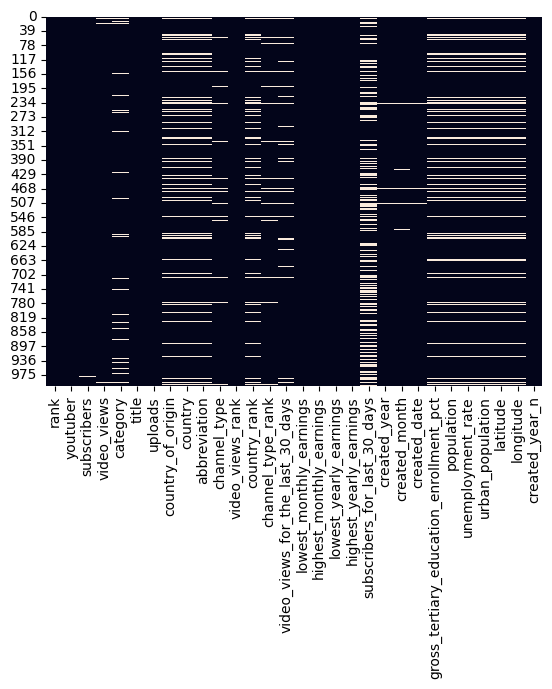

In [61]:
# Visualize Missing Values: Use heatmaps or other visualizations to understand the pattern of missing data.
sns.heatmap(df0.isnull(), cbar=False)
plt.show()

# 4 Data Visualization

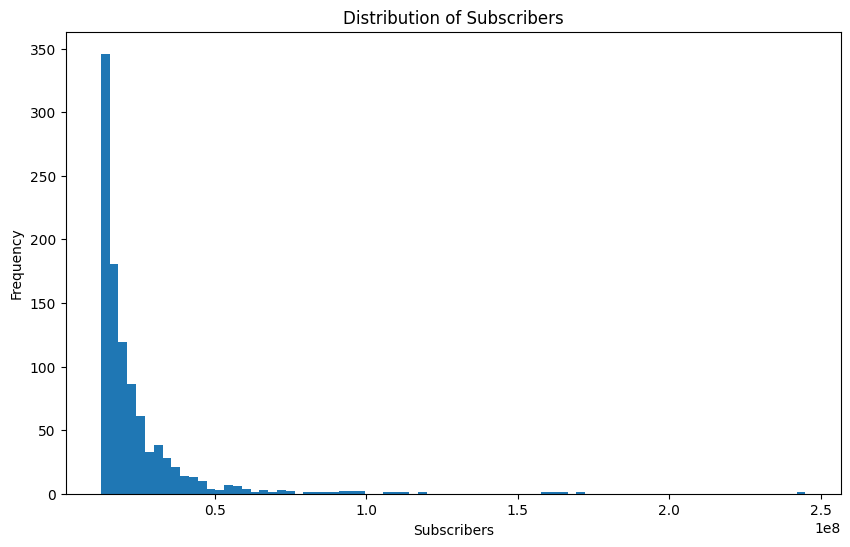

In [62]:
# View the target variable

plt.figure(figsize=(10, 6))  # Adjust figure size if needed
plt.hist(df0['subscribers'], bins=80)  # 'bins' controls the number of bars
plt.title('Distribution of Subscribers')
plt.xlabel('Subscribers')
plt.ylabel('Frequency')
# plt.xticks(np.arange(min(df0['subscribers']), max(df0['subscribers'])+1, 10000000)) # specify the x-axis interval

plt.show()


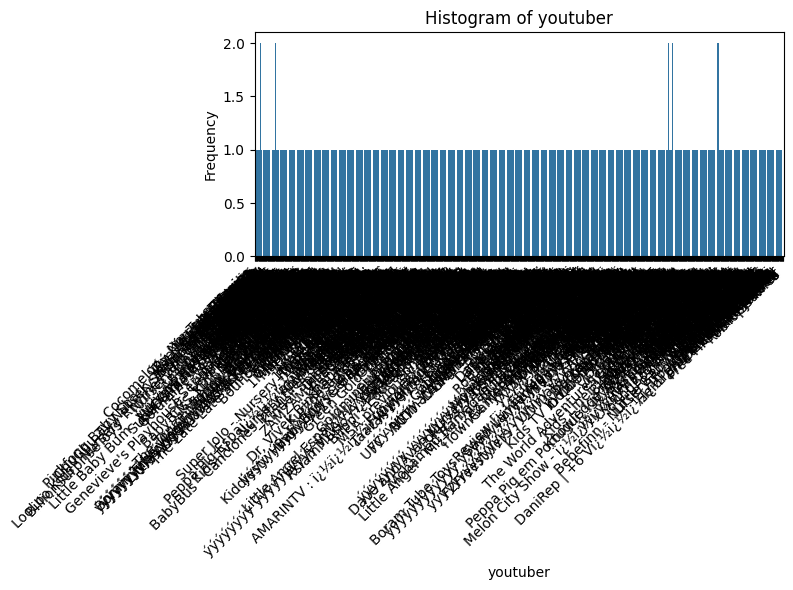

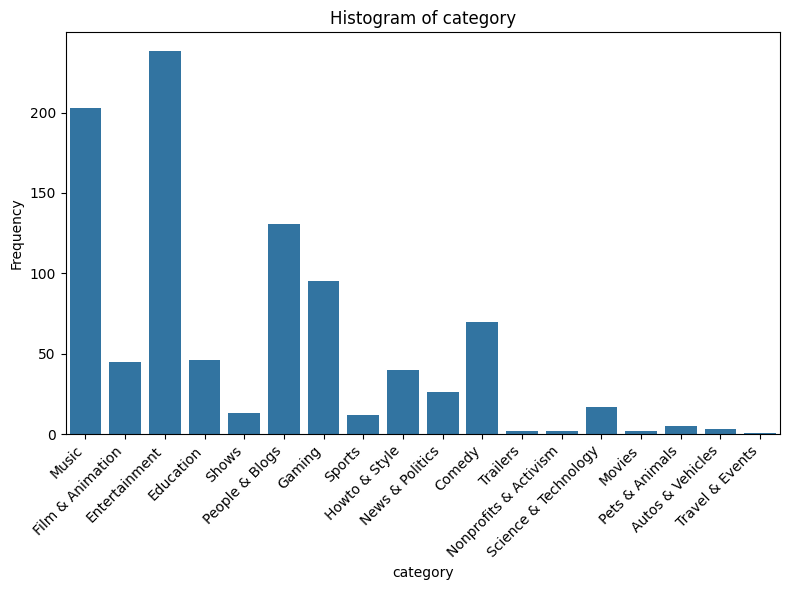

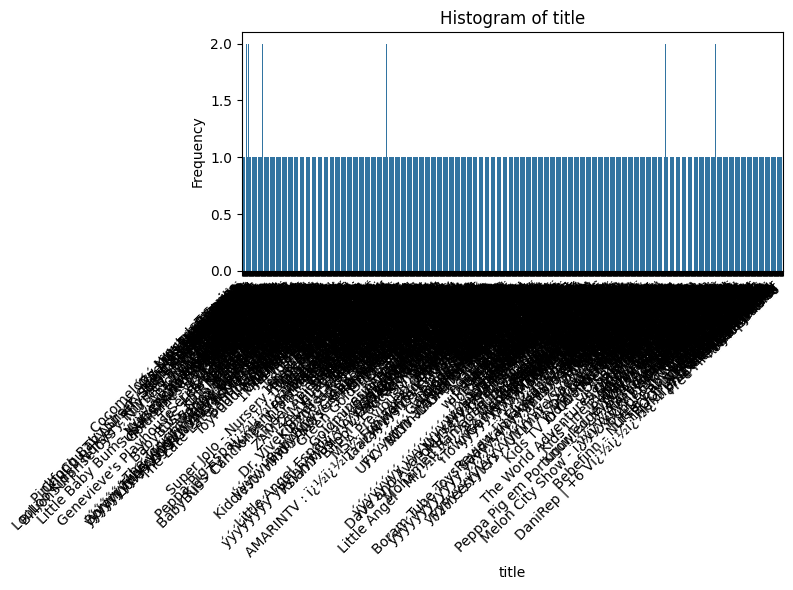

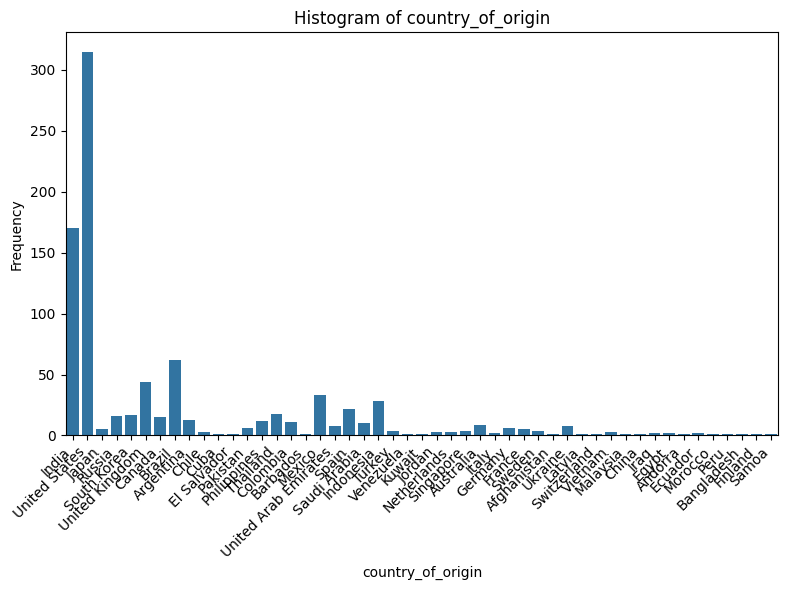

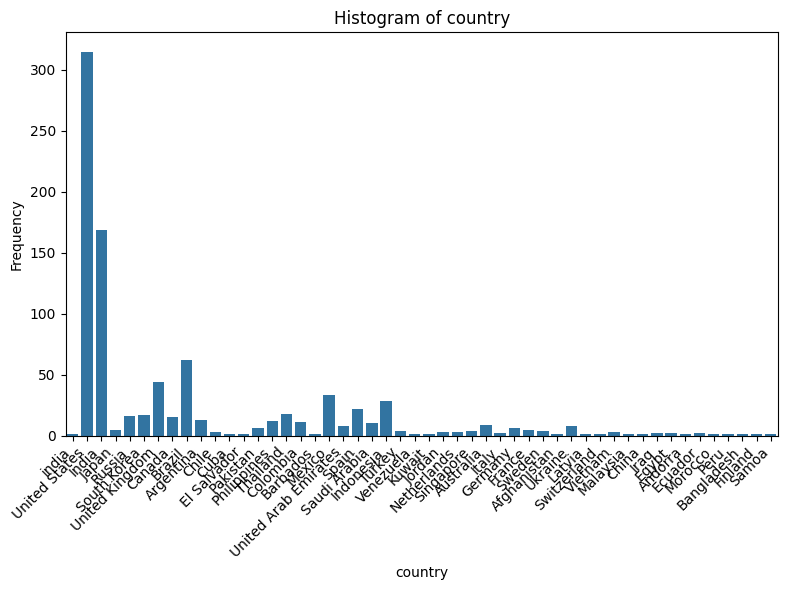

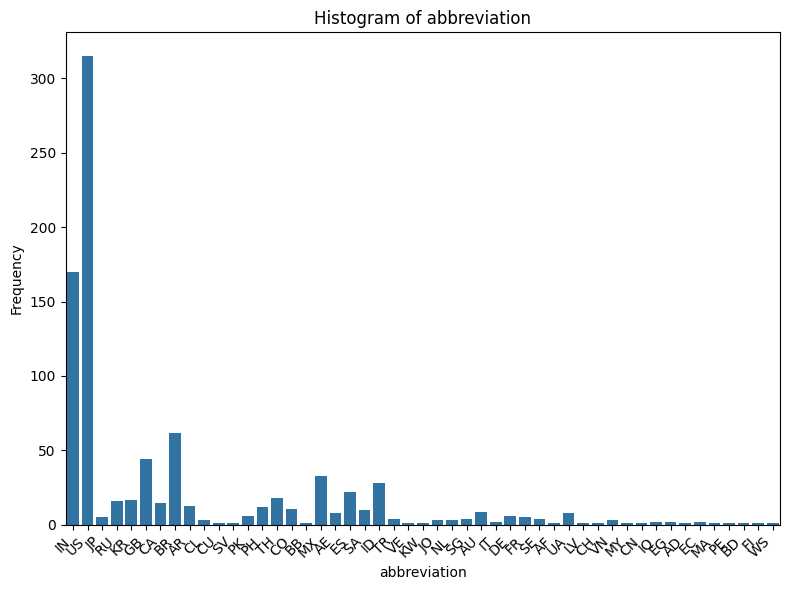

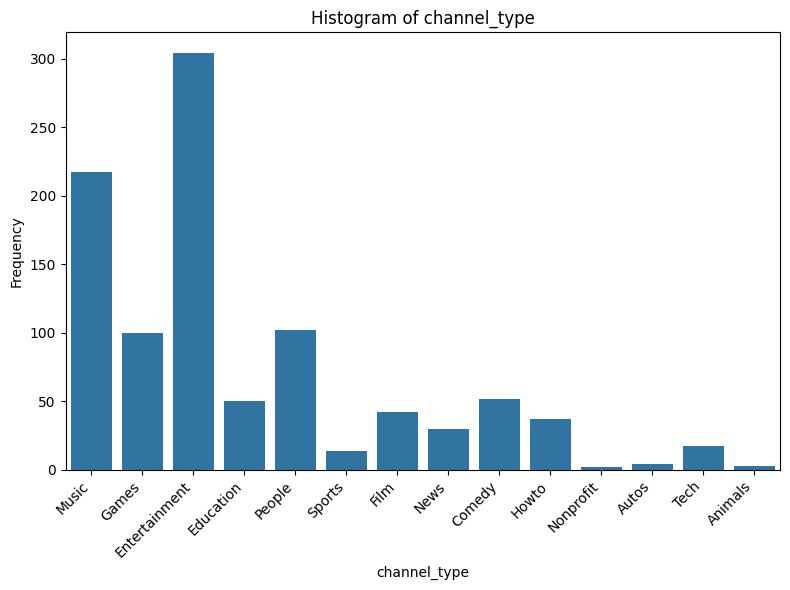

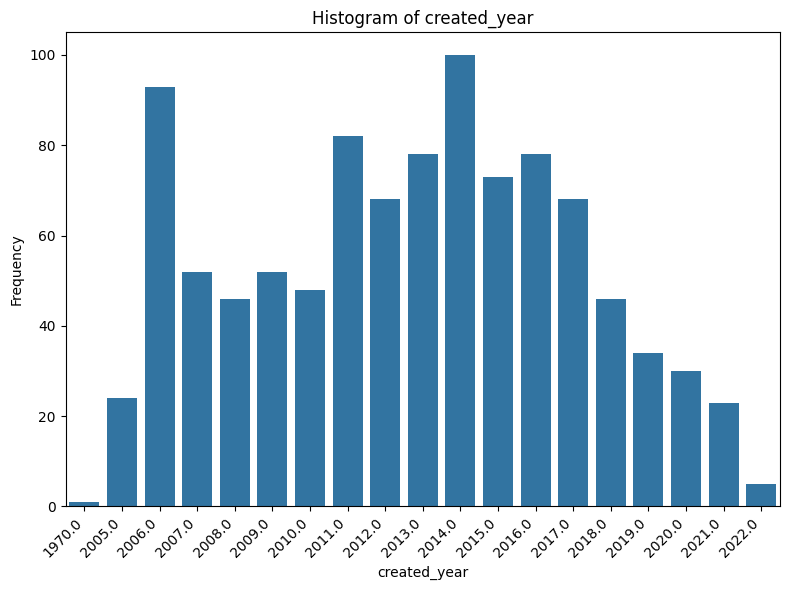

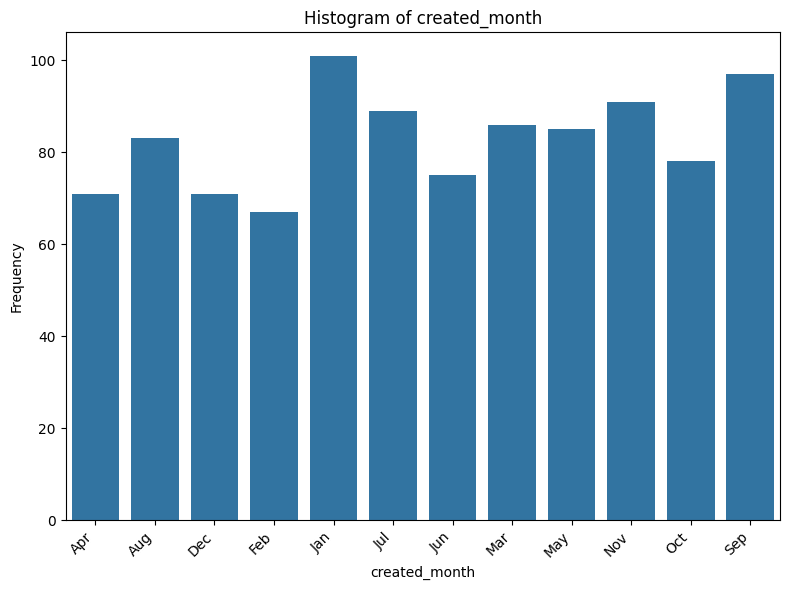

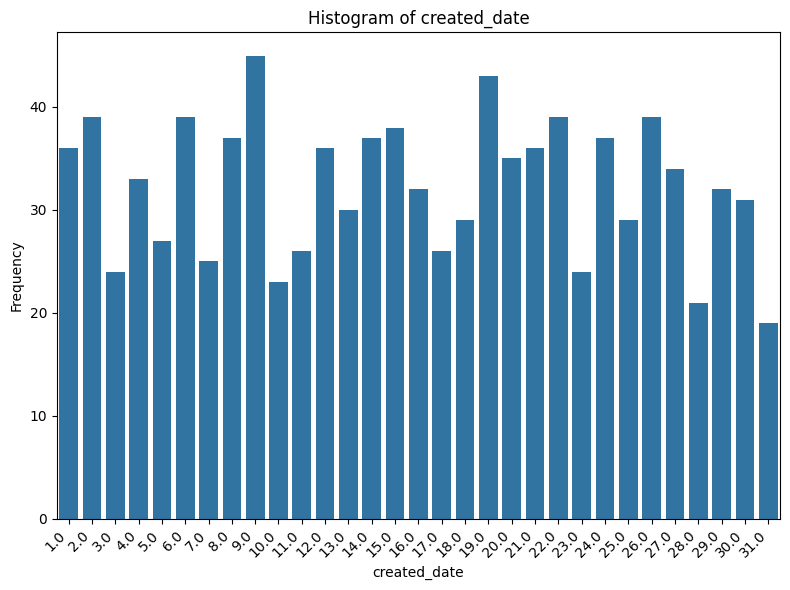

In [63]:
categorical_anly = [col for col in df0.select_dtypes(include=['object', 'category']).columns.tolist() if col not in ['Youtuber', 'Title', 'Abbreviation']]

for col in categorical_anly:
    plt.figure(figsize=(8, 6))  # Adjust figure size as needed
    sns.countplot(x=col, data=df0)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels if needed
    plt.tight_layout()
    plt.show()

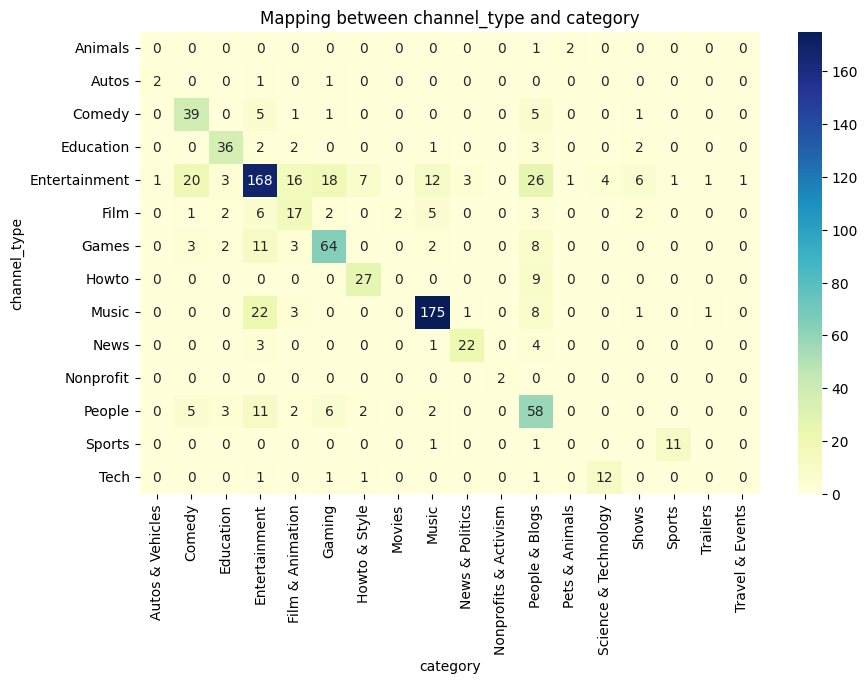

In [64]:
# check the relation between channel_type and category
mapping = pd.crosstab(df0['channel_type'], df0['category'])
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
sns.heatmap(mapping, annot=True, cmap="YlGnBu", fmt="d")
plt.title("Mapping between channel_type and category")
plt.xlabel("category")
plt.ylabel("channel_type")
plt.show()

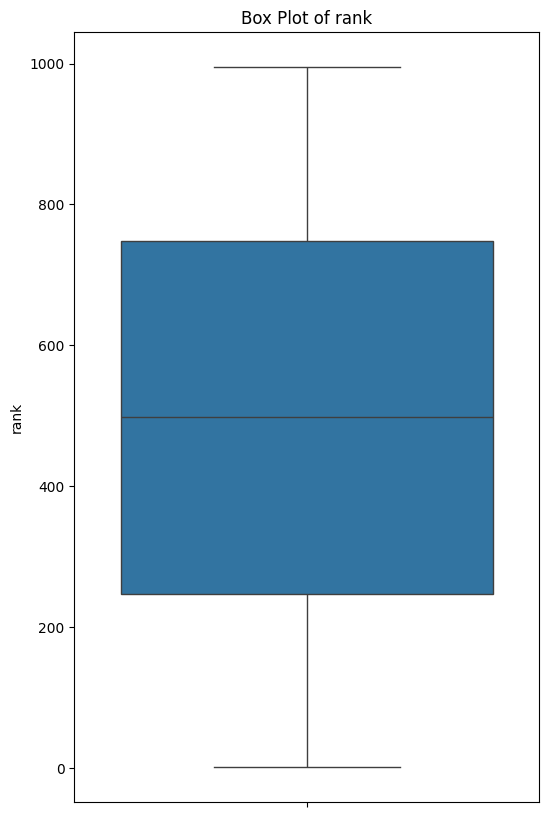

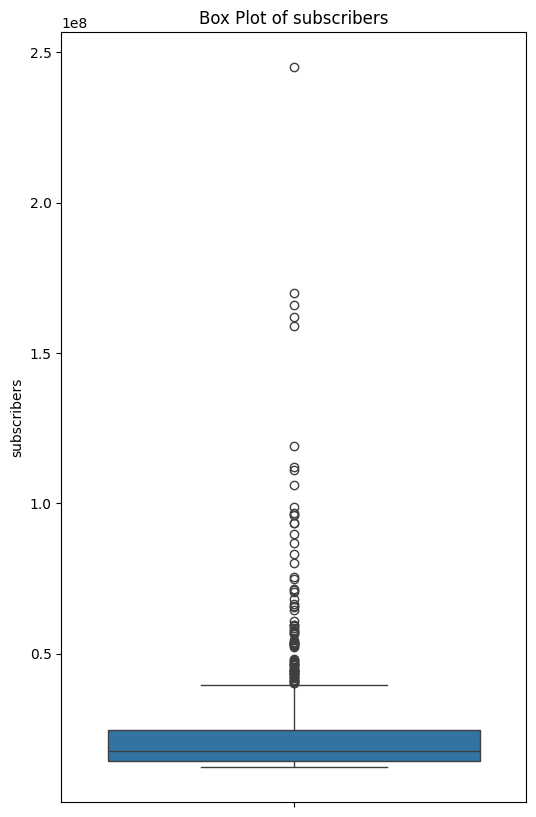

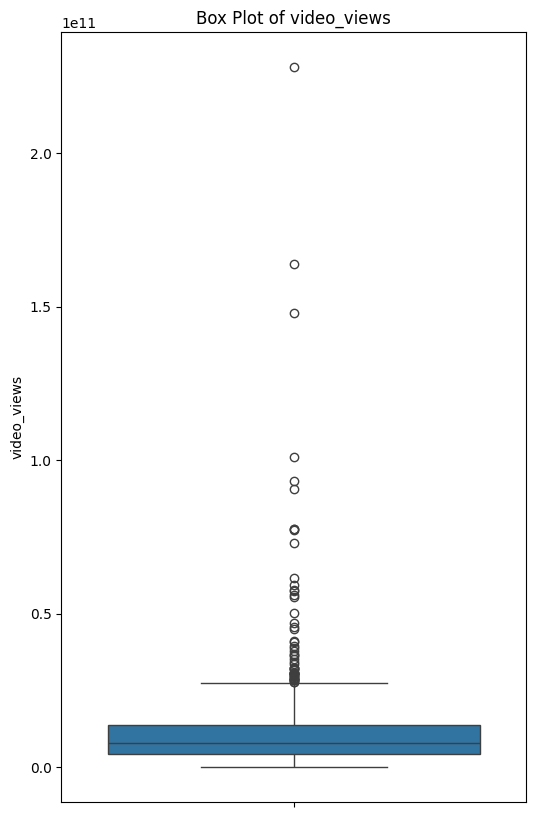

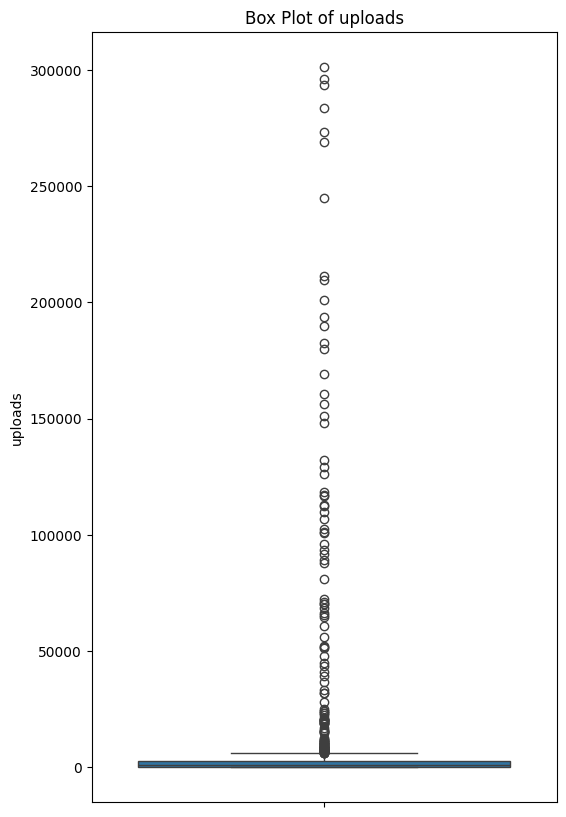

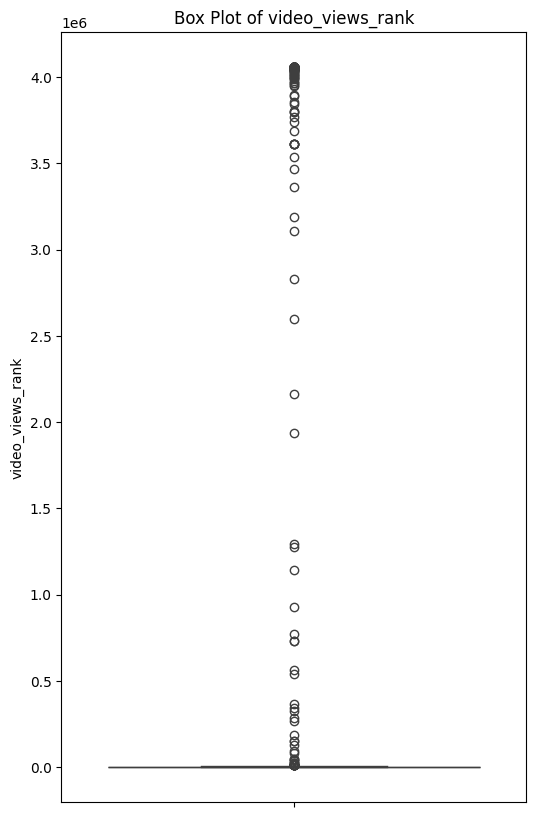

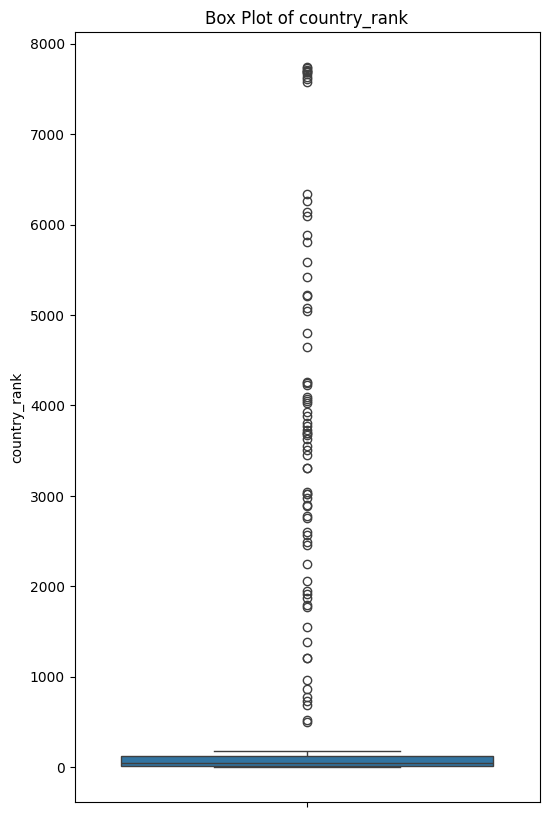

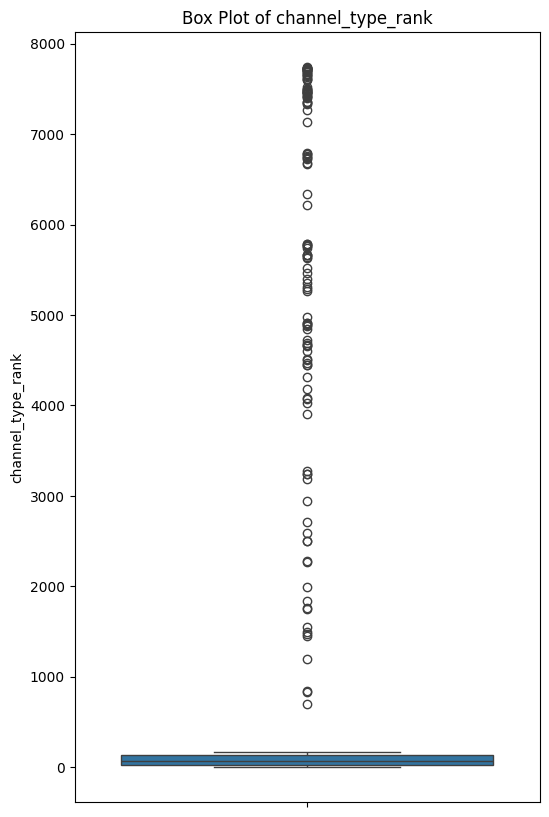

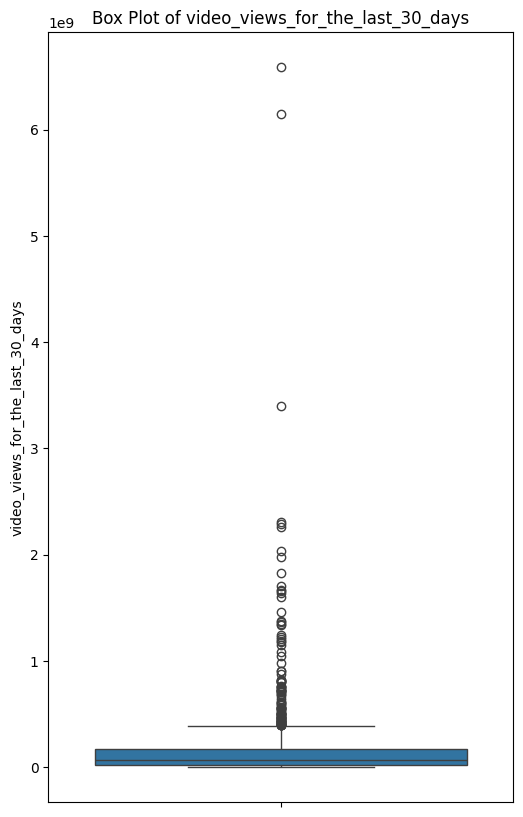

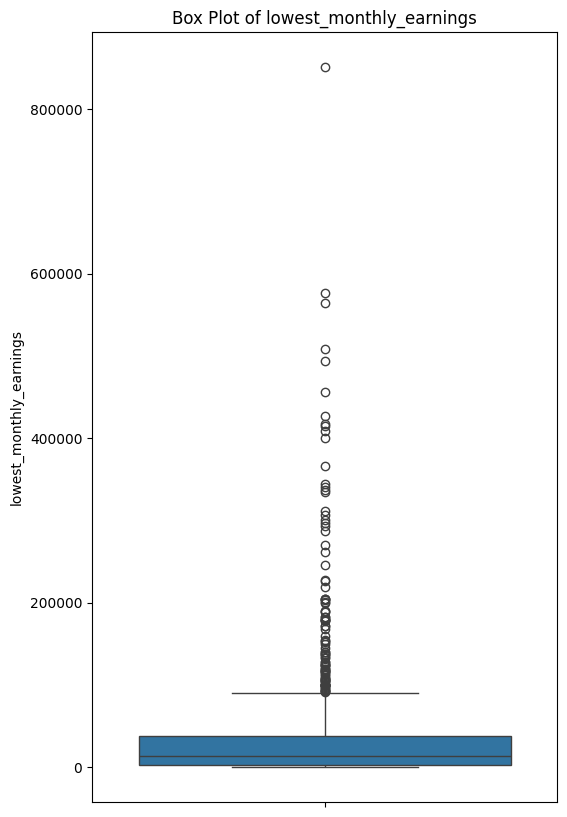

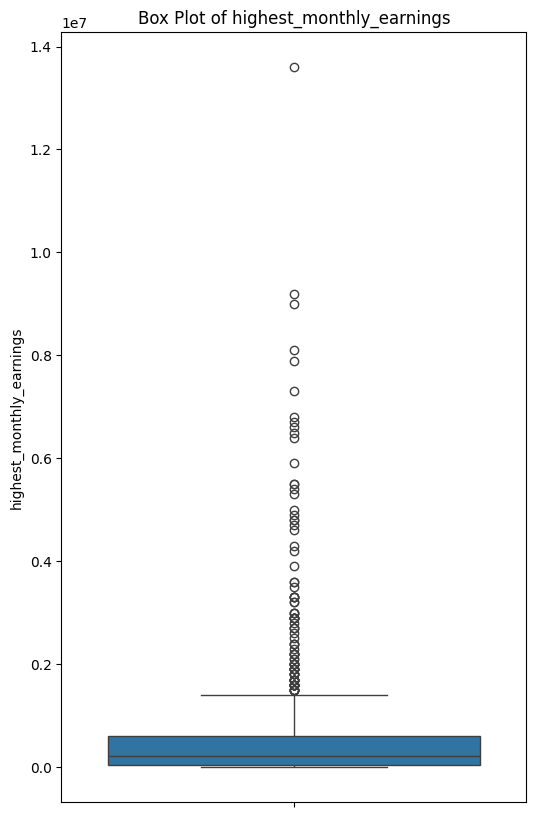

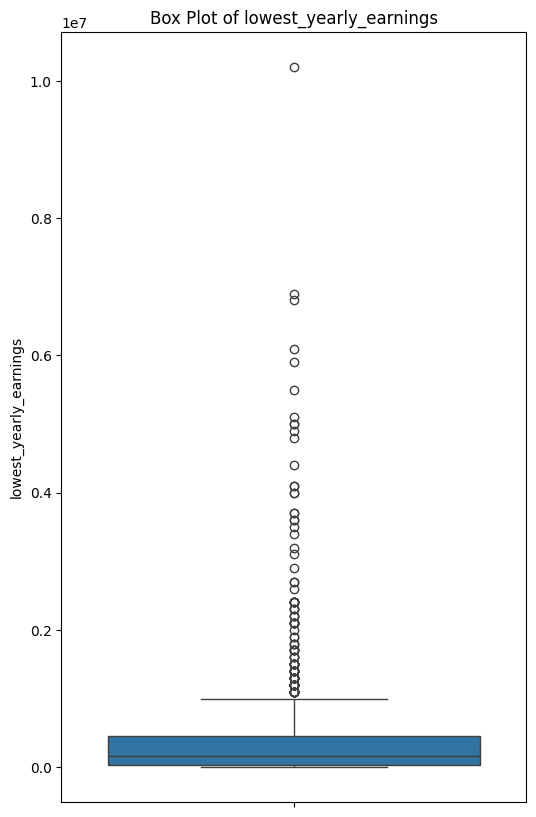

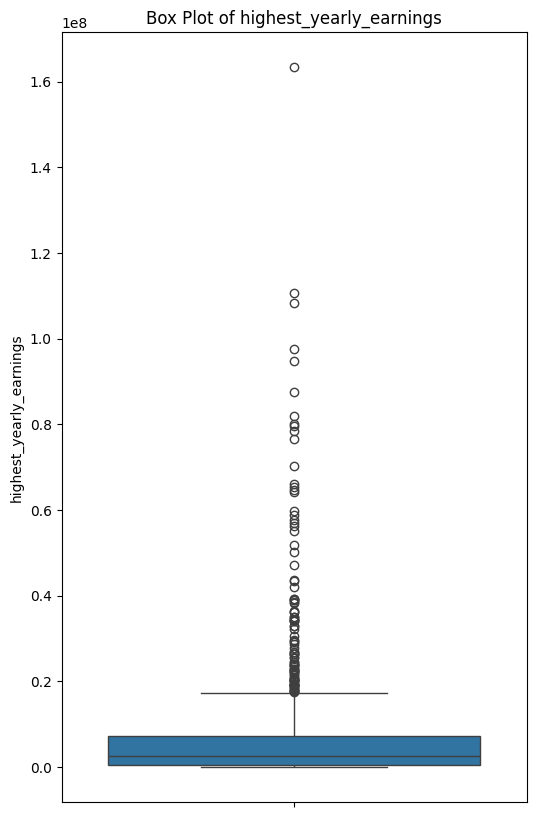

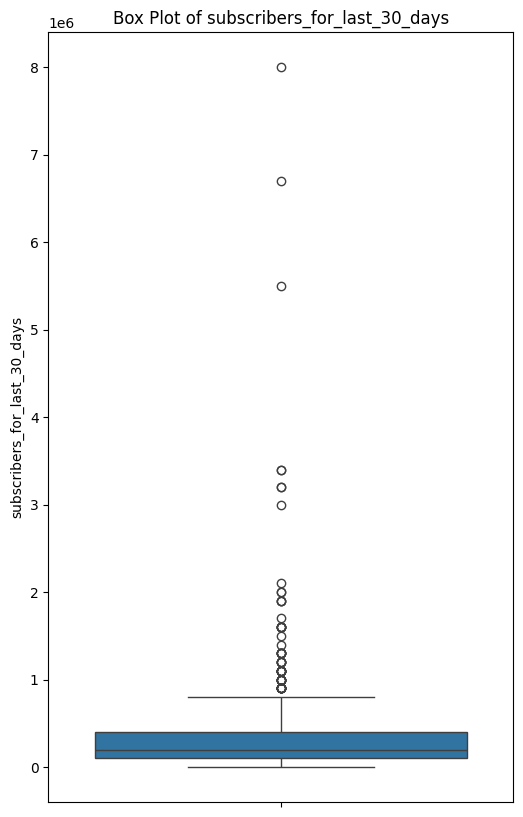

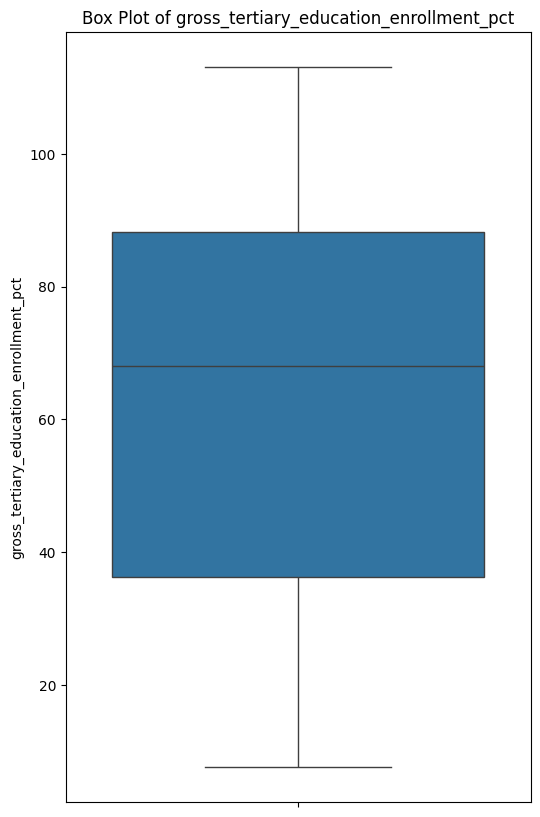

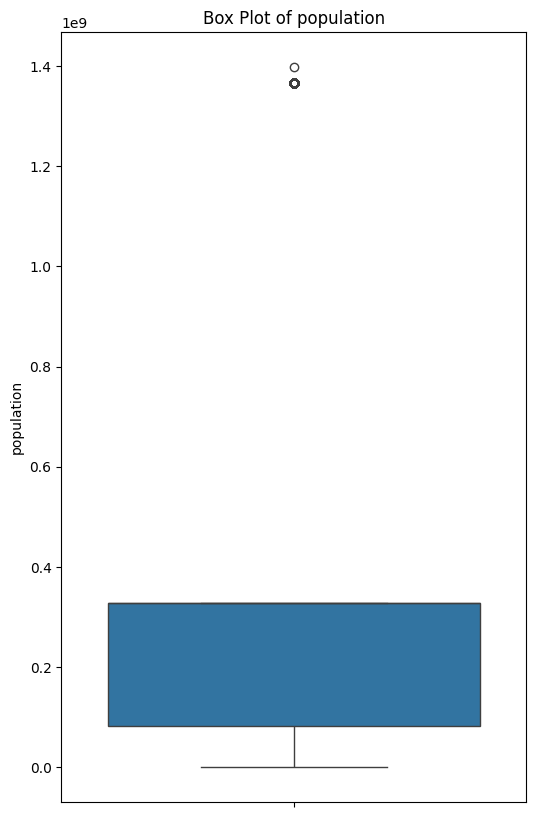

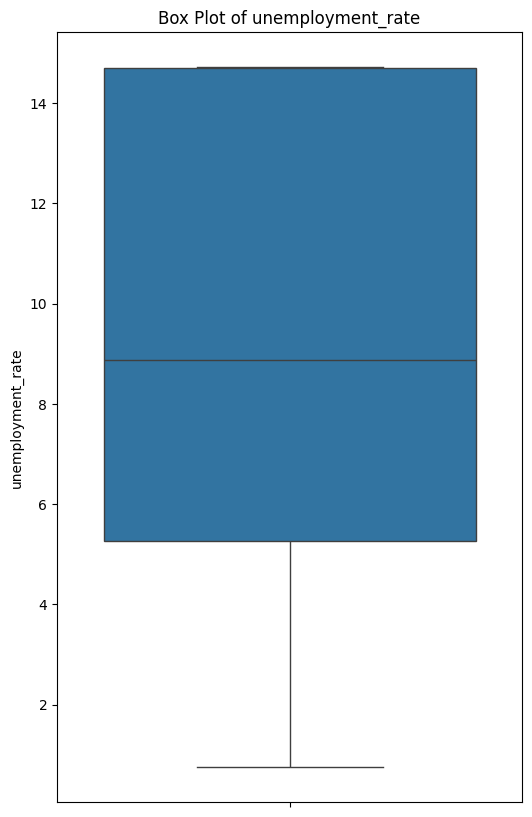

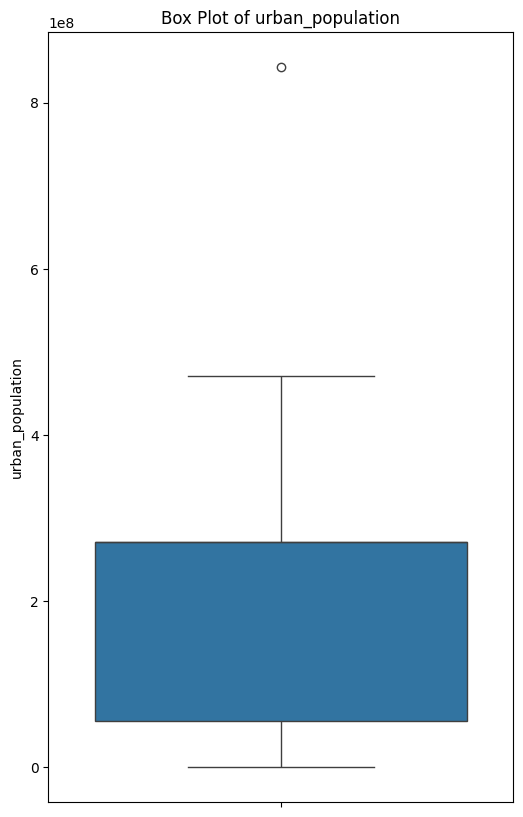

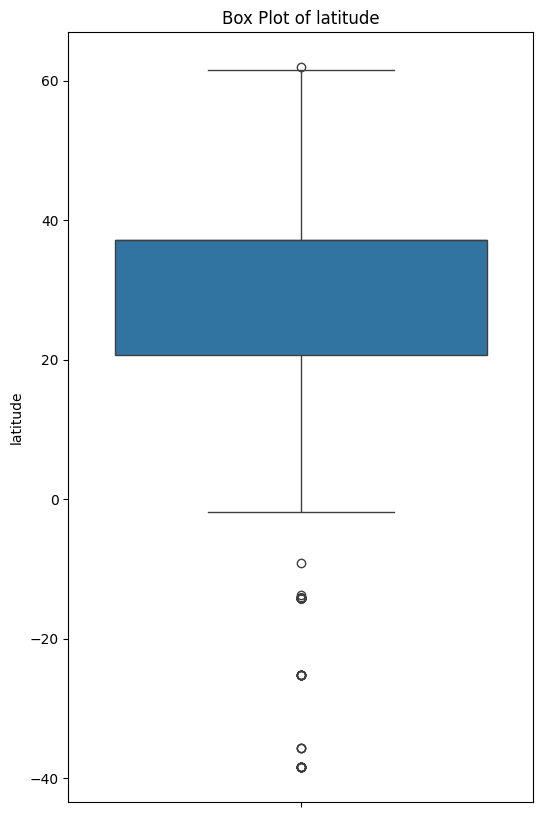

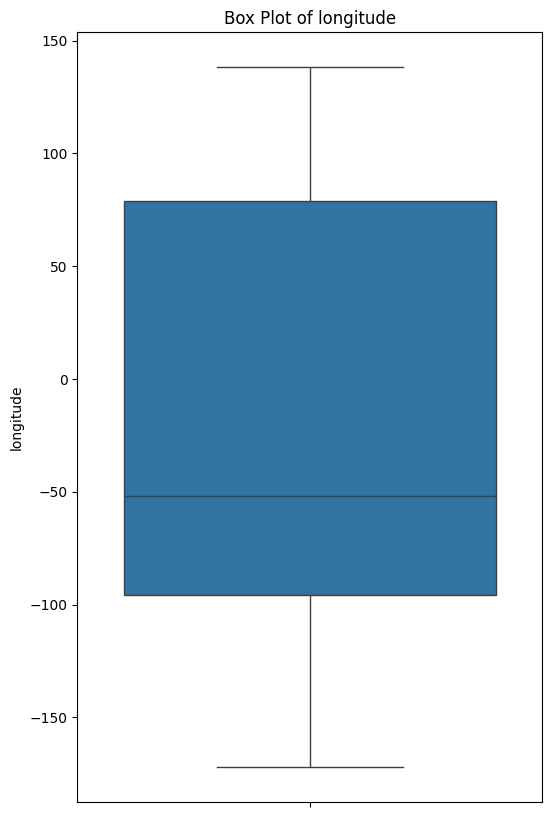

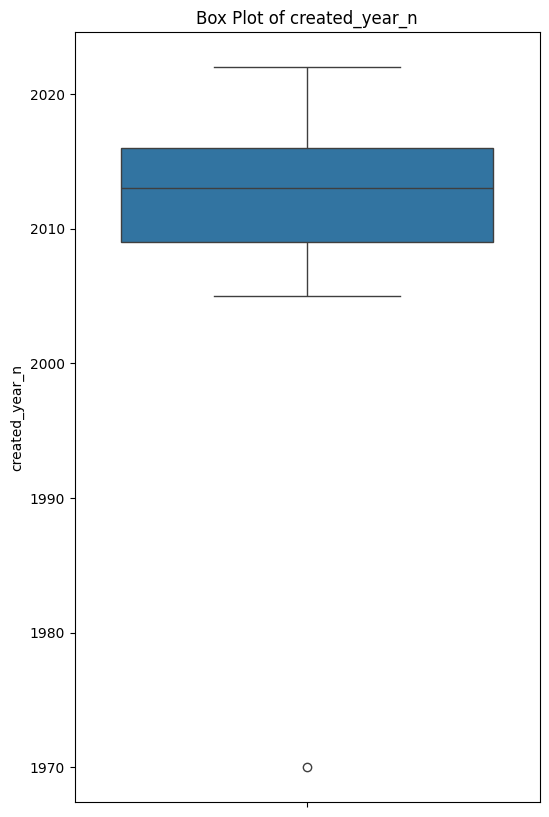

In [65]:
# Box Plots: Identify outliers and compare distributions.
for col in numerical_cols:
    plt.figure(figsize=(6, 10))
    sns.boxplot(y=col, data=df0)
    plt.title(f'Box Plot of {col}')
    plt.ylabel(col)
    plt.show()

In [66]:
# Scatter Plots: Explore relationships between two numerical variables.
# Iterate through all possible pairs of numerical columns
for col1, col2 in itertools.combinations(numerical_cols, 2):
    plt.figure(figsize=(8, 6))  # Adjust figure size as needed
    sns.scatterplot(x=col1, y=col2, data=df0)
    plt.title(f'Scatter Plot of {col1} vs. {col2}')
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

# 5 Correlation Analysis

In [67]:
# Correlation Matrix: Calculate correlations between numerical columns.
correlation_matrix = df0[numerical_cols].corr()
display(correlation_matrix.style.background_gradient(cmap='coolwarm'))

,rank,subscribers,video_views,uploads,video_views_rank,country_rank,channel_type_rank,video_views_for_the_last_30_days,lowest_monthly_earnings,highest_monthly_earnings,lowest_yearly_earnings,highest_yearly_earnings,subscribers_for_last_30_days,gross_tertiary_education_enrollment_pct,population,unemployment_rate,urban_population,latitude,longitude,created_year_n
rank,1.000000,-0.645320,-0.471820,-0.053017,-0.063765,0.017289,-0.027958,-0.189859,-0.251468,-0.251221,-0.251499,-0.251457,-0.192822,-0.037263,-0.026965,-0.015926,-0.041016,-0.003605,0.021136,0.103692
subscribers,-0.645320,1.000000,0.829032,0.080698,0.065408,0.029406,0.021945,0.282195,0.388222,0.388028,0.388108,0.388210,0.310160,-0.004997,0.082793,-0.005562,0.084963,0.025505,0.018476,-0.142175
video_views,-0.471820,0.829032,1.000000,0.169702,-0.044809,-0.062387,-0.046929,0.363348,0.552090,0.551603,0.552540,0.552076,0.189778,-0.010147,0.079003,0.005638,0.078684,0.042495,0.024308,-0.132129
uploads,-0.053017,0.080698,0.169702,1.000000,-0.109956,-0.078555,-0.098573,0.103409,0.169095,0.169489,0.169857,0.169072,0.009630,-0.214595,0.141468,-0.183113,0.073334,-0.066470,0.228508,-0.155611
video_views_rank,-0.063765,0.065408,-0.044809,-0.109956,1.000000,0.877592,0.944012,-0.070071,-0.211190,-0.211256,-0.211292,-0.211178,-0.169047,0.047738,-0.103303,-0.028866,-0.122626,0.014733,-0.016268,0.007506
country_rank,0.017289,0.029406,-0.062387,-0.078555,0.877592,1.000000,0.897860,-0.099687,-0.149852,-0.149861,-0.149935,-0.149851,-0.127327,0.104053,-0.053673,0.066518,-0.025257,0.046741,-0.071758,-0.032015
channel_type_rank,-0.027958,0.021945,-0.046929,-0.098573,0.944012,0.897860,1.000000,-0.130099,-0.188694,-0.188751,-0.188792,-0.188683,-0.155443,0.064582,-0.117660,0.002115,-0.125963,0.006770,-0.052190,-0.009893
video_views_for_the_last_30_days,-0.189859,0.282195,0.363348,0.103409,-0.070071,-0.099687,-0.130099,1.000000,0.682430,0.682389,0.682374,0.682430,0.454244,-0.037190,0.056044,-0.002258,0.053440,-0.025952,0.048670,0.050831
lowest_monthly_earnings,-0.251468,0.388222,0.552090,0.169095,-0.211190,-0.149852,-0.188694,0.682430,1.000000,0.999954,0.999939,0.999998,0.681226,-0.064294,0.107431,-0.042711,0.084092,0.007659,0.099697,0.068352
highest_monthly_earnings,-0.251221,0.388028,0.551603,0.169489,-0.211256,-0.149861,-0.188751,0.682389,0.999954,1.000000,0.999877,0.999953,0.681566,-0.064069,0.107462,-0.042428,0.084186,0.007957,0.099593,0.068292


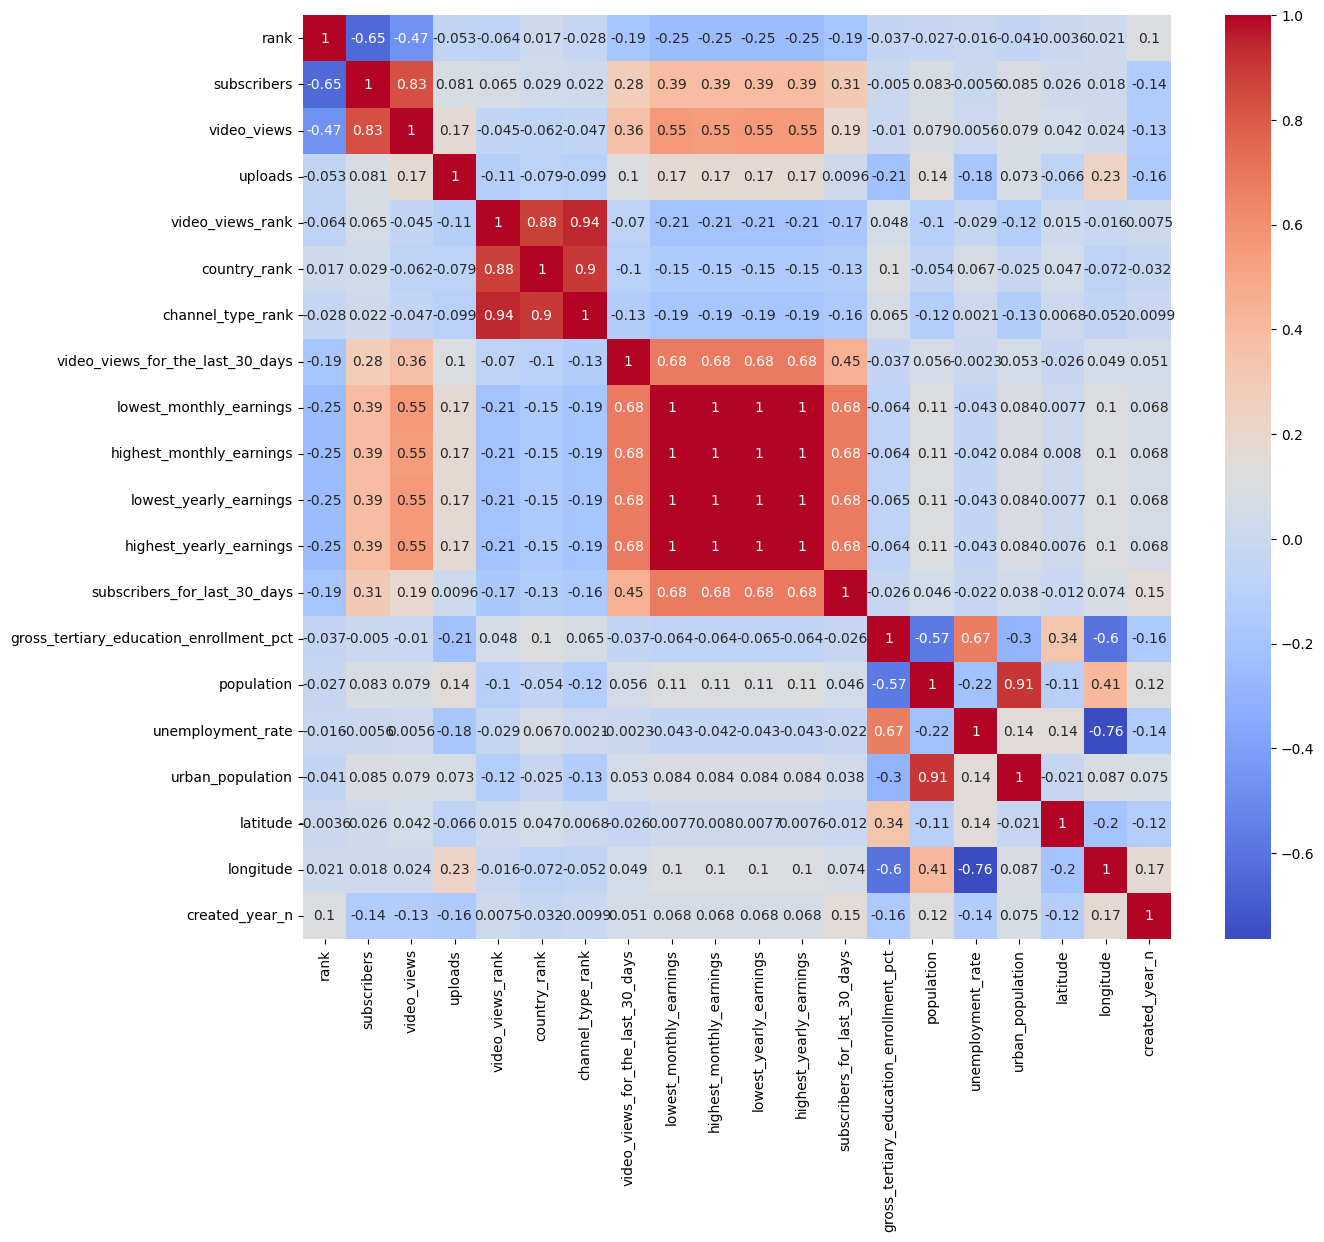

In [68]:
# Heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [69]:
# drop earnings vars
selected_cols = [col for col in numerical_cols if col not in ["lowest_monthly_earnings", "highest_monthly_earnings", "lowest_yearly_earnings", "highest_yearly_earnings"]]
correlation_matrix = df0[selected_cols].corr()
display(correlation_matrix.style.background_gradient(cmap='coolwarm'))


,rank,subscribers,video_views,uploads,video_views_rank,country_rank,channel_type_rank,video_views_for_the_last_30_days,subscribers_for_last_30_days,gross_tertiary_education_enrollment_pct,population,unemployment_rate,urban_population,latitude,longitude,created_year_n
rank,1.000000,-0.645320,-0.471820,-0.053017,-0.063765,0.017289,-0.027958,-0.189859,-0.192822,-0.037263,-0.026965,-0.015926,-0.041016,-0.003605,0.021136,0.103692
subscribers,-0.645320,1.000000,0.829032,0.080698,0.065408,0.029406,0.021945,0.282195,0.310160,-0.004997,0.082793,-0.005562,0.084963,0.025505,0.018476,-0.142175
video_views,-0.471820,0.829032,1.000000,0.169702,-0.044809,-0.062387,-0.046929,0.363348,0.189778,-0.010147,0.079003,0.005638,0.078684,0.042495,0.024308,-0.132129
uploads,-0.053017,0.080698,0.169702,1.000000,-0.109956,-0.078555,-0.098573,0.103409,0.009630,-0.214595,0.141468,-0.183113,0.073334,-0.066470,0.228508,-0.155611
video_views_rank,-0.063765,0.065408,-0.044809,-0.109956,1.000000,0.877592,0.944012,-0.070071,-0.169047,0.047738,-0.103303,-0.028866,-0.122626,0.014733,-0.016268,0.007506
country_rank,0.017289,0.029406,-0.062387,-0.078555,0.877592,1.000000,0.897860,-0.099687,-0.127327,0.104053,-0.053673,0.066518,-0.025257,0.046741,-0.071758,-0.032015
channel_type_rank,-0.027958,0.021945,-0.046929,-0.098573,0.944012,0.897860,1.000000,-0.130099,-0.155443,0.064582,-0.117660,0.002115,-0.125963,0.006770,-0.052190,-0.009893
video_views_for_the_last_30_days,-0.189859,0.282195,0.363348,0.103409,-0.070071,-0.099687,-0.130099,1.000000,0.454244,-0.037190,0.056044,-0.002258,0.053440,-0.025952,0.048670,0.050831
subscribers_for_last_30_days,-0.192822,0.310160,0.189778,0.009630,-0.169047,-0.127327,-0.155443,0.454244,1.000000,-0.025632,0.045666,-0.022031,0.037535,-0.012362,0.073565,0.151564
gross_tertiary_education_enrollment_pct,-0.037263,-0.004997,-0.010147,-0.214595,0.047738,0.104053,0.064582,-0.037190,-0.025632,1.000000,-0.573832,0.670529,-0.300549,0.336921,-0.599490,-0.160546


# 6 Modeling

## Create bins - mannual cutoff

In [70]:
# Define custom bin edges
df0['subscribers_million'] = (df0['subscribers'] / 1000000).round(2)

bins = [0, 15, 25, float('inf')]  # float('inf') represents infinity for the last bin
bin_labels = ['Under 15', '15-25', 'Above 25']

df0['class'] = pd.cut(df0['subscribers_million'], bins=bins, labels=bin_labels, include_lowest=True, right=False)

# Convert the 'class' column to the ordered categorical type
cat_type = pd.CategoricalDtype(categories=bin_labels, ordered=True)
df0['class'] = df0['class'].astype(cat_type)


In [71]:
df0['class'].value_counts()

,count
class,
15-25,452
Under 15,304
Above 25,247


In [72]:
df0[['subscribers', 'subscribers_million', 'class']].sample(5)

,subscribers,subscribers_million,class
420,19400000.0,19.4,15-25
489,17900000.0,17.9,15-25
228,25500000.0,25.5,Above 25
642,15400000.0,15.4,15-25
295,23000000.0,23.0,15-25


## Input features conversion

In [73]:
# Select input variables
df1 = df0.filter(items=['class','video_views','category','uploads','video_views_for_the_last_30_days','created_year_n','gross_tertiary_education_enrollment_pct','unemployment_rate','urban_population','latitude','longitude'])
df1.head()

,class,video_views,category,uploads,video_views_for_the_last_30_days,created_year_n,gross_tertiary_education_enrollment_pct,unemployment_rate,urban_population,latitude,longitude
0,Above 25,2.280000e+11,Music,20082,2.258000e+09,2006,28.1,5.36,471031528.0,20.593684,78.962880
1,Above 25,NaN,Film & Animation,1,1.200000e+01,2006,88.2,14.70,270663028.0,37.090240,-95.712891
2,Above 25,2.836884e+10,Entertainment,741,1.348000e+09,2012,88.2,14.70,270663028.0,37.090240,-95.712891
3,Above 25,1.640000e+11,Education,966,1.975000e+09,2006,88.2,14.70,270663028.0,37.090240,-95.712891
4,Above 25,1.480000e+11,Shows,116536,1.824000e+09,2006,28.1,5.36,471031528.0,20.593684,78.962880


In [74]:
# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit the encoder to the 'category' column and transform it
df1['category_encoded'] = label_encoder.fit_transform(df1['category'])

# View the updated DataFrame
df1.head()

,class,video_views,category,uploads,video_views_for_the_last_30_days,created_year_n,gross_tertiary_education_enrollment_pct,unemployment_rate,urban_population,latitude,longitude,category_encoded
0,Above 25,2.280000e+11,Music,20082,2.258000e+09,2006,28.1,5.36,471031528.0,20.593684,78.962880,8
1,Above 25,NaN,Film & Animation,1,1.200000e+01,2006,88.2,14.70,270663028.0,37.090240,-95.712891,4
2,Above 25,2.836884e+10,Entertainment,741,1.348000e+09,2012,88.2,14.70,270663028.0,37.090240,-95.712891,3
3,Above 25,1.640000e+11,Education,966,1.975000e+09,2006,88.2,14.70,270663028.0,37.090240,-95.712891,2
4,Above 25,1.480000e+11,Shows,116536,1.824000e+09,2006,28.1,5.36,471031528.0,20.593684,78.962880,14


## Linear Regression Model

In [127]:
# Select input variables for linear regression
df1 = df0.filter(items=['subscribers_million','video_views','category','uploads','video_views_for_the_last_30_days','created_year_n','gross_tertiary_education_enrollment_pct','unemployment_rate','urban_population','latitude','longitude'])

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit the encoder to the 'category' column and transform it
df1['category_encoded'] = label_encoder.fit_transform(df1['category'])

df1 = df1.drop('category', axis=1) # Remove the original categorical column

# View the updated DataFrame
df1.head()


,subscribers_million,video_views,uploads,video_views_for_the_last_30_days,created_year_n,gross_tertiary_education_enrollment_pct,unemployment_rate,urban_population,latitude,longitude,category_encoded
0,245.0,2.280000e+11,20082,2.258000e+09,2006,28.1,5.36,471031528.0,20.593684,78.962880,8
1,170.0,NaN,1,1.200000e+01,2006,88.2,14.70,270663028.0,37.090240,-95.712891,4
2,166.0,2.836884e+10,741,1.348000e+09,2012,88.2,14.70,270663028.0,37.090240,-95.712891,3
3,162.0,1.640000e+11,966,1.975000e+09,2006,88.2,14.70,270663028.0,37.090240,-95.712891,2
4,159.0,1.480000e+11,116536,1.824000e+09,2006,28.1,5.36,471031528.0,20.593684,78.962880,14


In [131]:
df1.isnull().sum()  # Total missing values per column

,0
subscribers_million,3
video_views,9
uploads,0
video_views_for_the_last_30_days,57
created_year_n,0
gross_tertiary_education_enrollment_pct,126
unemployment_rate,126
urban_population,126
latitude,126
longitude,126


In [132]:
# Remove rows with missing values
df1.dropna(inplace=True)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder


# 1. Prepare the data
# Select features (X) and target (y)
X = df1.drop('subscribers_million', axis=1)
y = df1['subscribers_million']

# 2. Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=309276)

# 3. Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# 4. Make predictions on the test set
y_pred = model.predict(X_test)


In [134]:
# 5. Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 40.84212460434139
R-squared: 0.8382519956561203


In [136]:
# Get the feature names from the DataFrame used for training
feature_names = X_train.columns.tolist()

# Create a DataFrame to store coefficients and feature names
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': model.coef_})

# Print the DataFrame
print(coef_df)

                                   Feature   Coefficient
0                              video_views  9.683907e-10
1                                  uploads -2.631253e-05
2         video_views_for_the_last_30_days  6.783758e-10
3                           created_year_n -1.560554e-01
4  gross_tertiary_education_enrollment_pct  3.564447e-02
5                        unemployment_rate -2.718429e-01
6                         urban_population  7.438244e-09
7                                 latitude -1.826515e-02
8                                longitude -1.194726e-03
9                         category_encoded  3.747653e-02


In [137]:
# Print results with p values

# Add a constant term to the features (required for statsmodels)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)  # Add constant to test data as well

# Create and train the linear regression model using statsmodels
model = sm.OLS(y_train, X_train).fit()

# Get the feature names from the DataFrame used for training
feature_names = X_train.columns.tolist()

# Create a DataFrame to store coefficients, p-values, and feature names
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': model.params, 'P-value': model.pvalues})

# Print the DataFrame
print(coef_df)

                                                                         Feature  \
const                                                                      const   
video_views                                                          video_views   
uploads                                                                  uploads   
video_views_for_the_last_30_days                video_views_for_the_last_30_days   
created_year_n                                                    created_year_n   
gross_tertiary_education_enrollment_pct  gross_tertiary_education_enrollment_pct   
unemployment_rate                                              unemployment_rate   
urban_population                                                urban_population   
latitude                                                                latitude   
longitude                                                              longitude   
category_encoded                                                category_enc

## Random Forest Models

### Prep

In [75]:
# Select input variables
df = df1.filter(items=['class','video_views','category_encoded','uploads','video_views_for_the_last_30_days','created_year_n','gross_tertiary_education_enrollment_pct','unemployment_rate','urban_population','latitude','longitude'])
df.head()


,class,video_views,category_encoded,uploads,video_views_for_the_last_30_days,created_year_n,gross_tertiary_education_enrollment_pct,unemployment_rate,urban_population,latitude,longitude
0,Above 25,2.280000e+11,8,20082,2.258000e+09,2006,28.1,5.36,471031528.0,20.593684,78.962880
1,Above 25,NaN,4,1,1.200000e+01,2006,88.2,14.70,270663028.0,37.090240,-95.712891
2,Above 25,2.836884e+10,3,741,1.348000e+09,2012,88.2,14.70,270663028.0,37.090240,-95.712891
3,Above 25,1.640000e+11,2,966,1.975000e+09,2006,88.2,14.70,270663028.0,37.090240,-95.712891
4,Above 25,1.480000e+11,14,116536,1.824000e+09,2006,28.1,5.36,471031528.0,20.593684,78.962880


In [76]:
df.isnull().sum()  # Total missing values per column

,0
class,3
video_views,9
category_encoded,0
uploads,0
video_views_for_the_last_30_days,57
created_year_n,0
gross_tertiary_education_enrollment_pct,126
unemployment_rate,126
urban_population,126
latitude,126


In [77]:
# Remove rows with missing values
df.dropna(inplace=True)

In [85]:
# Generate 5 random seeds
import random
import hashlib

def md5_hash(input_string):
  """Generates an MD5 hash from a given string.
  Args:
    input_string: The string to hash.
  Returns:
    The MD5 hash as a hexadecimal string.
  """
  md5_hasher = hashlib.md5()
  md5_hasher.update(input_string.encode('utf-8'))
  return md5_hasher.hexdigest()

# Example usage
input_string = "309276"
hashed_value = md5_hash(input_string)
print(f"The MD5 hash of '{input_string}' is: {hashed_value}")

# Convert the hexadecimal hash to an integer
try:
    number = int(hashed_value, 16)
    print(f"The integer representation of the hash is: {number}")
except ValueError:
    print("Invalid hexadecimal string")

# Set the seed value
random.seed(number)

print(f"Initial seed number: {number}")

# Generate a list of 10 random numbers
random.seed(number)
a = 0
b = 2**31-1
random_numbers = [random.randint(a, b) for _ in range(5)]

# Print the list
print("Seed", random_numbers)


The MD5 hash of '309276' is: cede9b28d8235640f32e9a74a16181db
The integer representation of the hash is: 274976804043793949977936547566971879899
Initial seed number: 274976804043793949977936547566971879899
Seed [1724286445, 274166639, 84465423, 1610518818, 92137541]


In [93]:
# Define random seeds
random_seeds = [1724286445, 274166639, 84465423, 1610518818, 92137541]

# Split data into train, validation, and test sets
X = df.drop('class', axis=1)
y = df['class']
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_seeds[0]
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=random_seeds[0]
)

In [94]:
# Define Optuna objective function
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 200)
    max_depth = trial.suggest_int("max_depth", 5, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=trial.suggest_categorical("random_state", random_seeds),
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    # Since 'class' is categorical, using accuracy for Optuna objective
    accuracy = accuracy_score(y_val, y_pred)
    return accuracy

In [ ]:
# Create Optuna study and optimize
study = optuna.create_study(direction="maximize") # Maximize accuracy
study.optimize(objective, n_trials=20)

# Get best hyperparameters
best_params = study.best_params

In [106]:
# Train final model and evaluate with different seeds
accuracies = []  # List to store accuracies for each seed

for seed in random_seeds:
    model = RandomForestClassifier(**best_params)
    model.fit(X_train_val, y_train_val)
    y_pred = model.predict(X_test)

    # Use accuracy_score instead of mean_absolute_error
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Calculate median and confidence interval of accuracies
median_accuracy = np.median(accuracies)
confidence_interval = np.percentile(accuracies, [2.5, 97.5])

In [108]:
# Choose the best model based on the highest accuracy
best_seed = random_seeds[np.argmax(accuracies)]

# Print results
print(f"Median Accuracy: {median_accuracy}")
print(f"95% Confidence Interval: {confidence_interval}")
print(f"Best Model Seed: {best_seed}")

Median Accuracy: 0.5906432748538012
95% Confidence Interval: [0.59064327 0.59064327]
Best Model Seed: 1724286445


### Prelim Model

In [ ]:
# Prelim Random Forest Model (using default parameters)

X = df.drop('class', axis=1)  # Features
y = df['class']  # Target variable

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=309276)

# Create a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=309276)

# Train the model using the training data
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

In [80]:
# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multi-class
print(f"F1 Score: {f1}")

F1 Score: 0.6258495378623734


In [81]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6257309941520468


In [82]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

Confusion Matrix:
[[51 11 15]
 [14 25  0]
 [23  1 31]]


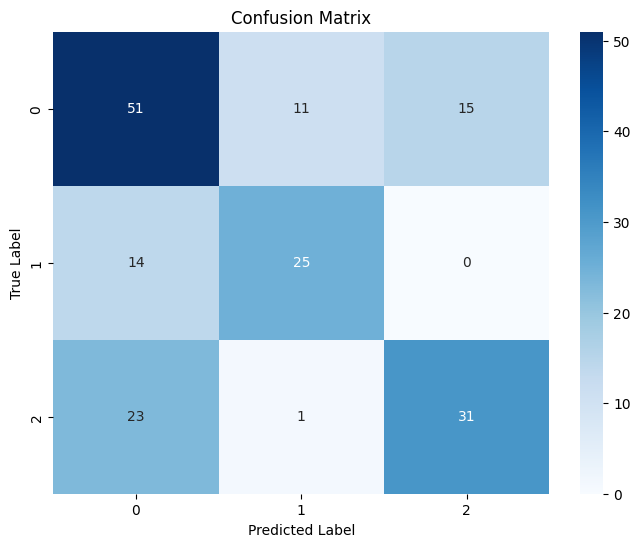

In [83]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

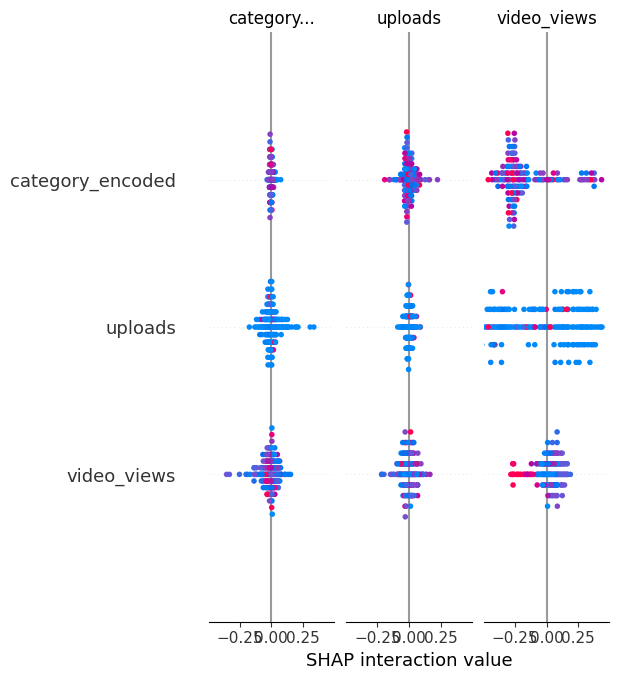

In [84]:
# Create a TreeExplainer for the Random Forest model
explainer = shap.TreeExplainer(rf_model)

# Calculate SHAP values for the test data
shap_values = explainer.shap_values(X_test)

# Summary plot to visualize feature importances and their contributions
shap.summary_plot(shap_values, X_test, plot_type="bar", plot_size=(6, 12))  # For overall feature importance


### Best Model

In [112]:
best_params

{'n_estimators': 123,
 'max_depth': 17,
 'min_samples_split': 6,
 'min_samples_leaf': 2,
 'random_state': 1724286445}

In [119]:
# Best Random Forest Model (using best parameters)
X = df.drop('class', axis=1)  # Features
y = df['class']  # Target variable

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=309276)

# Create a Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=123,
    max_depth=17,
    min_samples_split=6,
    min_samples_leaf=2,
    random_state=1724286445
)

# Train the model using the training data
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

In [120]:
# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multi-class
print(f"F1 Score: {f1}")

F1 Score: 0.6300113541238868


In [121]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.631578947368421


In [122]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

Confusion Matrix:
[[55 10 12]
 [14 25  0]
 [27  0 28]]


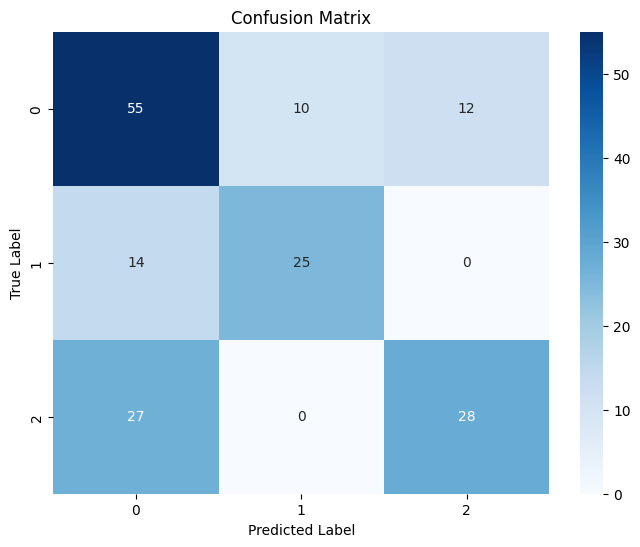

In [123]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

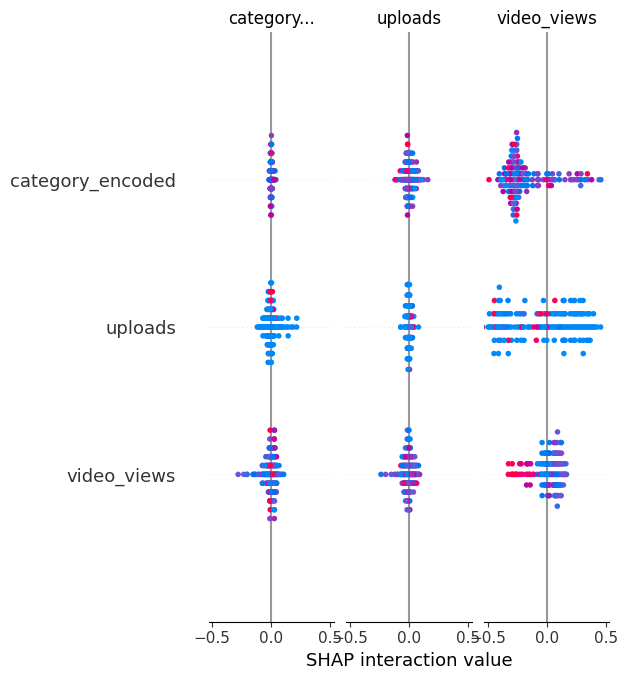

In [124]:
# Create a TreeExplainer for the Random Forest model
explainer = shap.TreeExplainer(rf_model)

# Calculate SHAP values for the test data
shap_values = explainer.shap_values(X_test)

# Summary plot to visualize feature importances and their contributions
shap.summary_plot(shap_values, X_test, plot_type="bar", plot_size=(6, 12))  # For overall feature importance
